# Verification of the implementation

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import pandas as pd
import json
from statsmodels.graphics.tsaplots import plot_acf
from math import exp

In [99]:
def extract_normal_from_file(path):
    with open(path, 'r') as input_file:
        data = json.load(input_file)

    if not isinstance(data, list):
        data = data['posteriors']

    mean = [d[0] for d in data]
    var = [d[1] for d in data]
    data_frame = pd.DataFrame({r'mean $\theta_1$': mean, r'var $\theta_2$': var})
    return data_frame

def extract_binom_from_file(path, from_abc=False):
    with open(path, 'r') as input_file:
        data = json.load(input_file)
        
    if not isinstance(data, list):
        data = data['posteriors']


    if from_abc:
        params = [d[0] for d in data]
        data_frame = pd.DataFrame({r'$\theta$ (ABC)': params,
                                   'p': [theta_to_p(t) for t in params]})
    else:
        params = [d[1] for d in data]
        data_frame = pd.DataFrame({'p': params})

    return data_frame

def theta_to_p(theta):
    return exp(theta)/(1 + exp(theta))



def summary(data):
    col_names = data.columns.values
    for i in [25,50,75]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.percentile(data[param_name], i)
            print("Q{} for {} parameter {}".format(i, param_name, q))


def plot_marginals(data, perfect_vals, burn_in=0, by=1):
    
    col_names = data.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,7*len(col_names)))
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
    
        if len(col_names) > 1:
            ax= axs[i,:]
        else:
            ax=axs
        params = data[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=ax[0])
        ax[0].axvline(perfect_vals[i], color='r', linestyle='--', label='expected value')

        # Path
        ax[1].plot(range(len(params)), params)
        ax[1].axhline(perfect_vals[i], color='r', linestyle='--', label='expected value')
        ax[1].set(xlabel='iterations', ylabel='{} parameter ABC'.format(param_name))

def comparison_normal_2d_path(data_mh, data_abc, burn_in=0, by=1):
    fig = plt.figure(figsize=(7, 14))
    outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.2)
    plot_normal_2d_path(data_abc, burn_in, by, fig, outer[0])
    plot_normal_2d_path(data_mh, burn_in, by, fig, outer[1])
    
    
def plot_normal_2d_path(data, burn_in=0, by=1, fig=None, outer=None):

    if fig is None or outer is None:
        fig = plt.figure(figsize=(12, 12))
        grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    else:
        grid = gridspec.GridSpecFromSubplotSpec(4, 4,
                    subplot_spec=outer, wspace=0.2, hspace=0.2)

    mean = data[r'mean $\theta_1$'].tolist()[burn_in::by]
    var = data[r'var $\theta_2$'].tolist()[burn_in::by]

    
    main_ax = fig.add_subplot(grid[:-1, 1:])
    var_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    mean_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    # scatter points on the main axes
    main_ax.plot(mean, var, markersize=3)

    # histogram on the attached axes
    mean_hist.hist(mean, 40, histtype='stepfilled', orientation='vertical')
    mean_hist.invert_yaxis()
    mean_hist.set(xlabel="Mean parameter")
    var_hist.hist(var, 40, histtype='stepfilled',orientation='horizontal')
    var_hist.invert_xaxis()
    var_hist.set(ylabel="Var parameter")


def comparaison(data_mh, data_abc, burn_in=0, by=1):
    col_names = data_mh.columns.values

    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,7*len(col_names)))
    
    for idx, param_name in np.ndenumerate(col_names):
    
        i = idx[0]
        # Sample parameter
        if len(col_names) > 1:
            ax= axs[i,:]
        else:
            ax=axs
        params_abc = data_abc[param_name].tolist()[burn_in::by]
        params_mh = data_mh[param_name].tolist()[burn_in::by]
        df = pd.DataFrame({"MH - {}".format(param_name): params_mh, "ABC - {}".format(param_name): params_abc})
        ax[0].set_title(label="Distribution - {}".format(param_name))
        sns.boxplot(data=df, ax=ax[0])
    
        ax[1].scatter(sorted(params_mh), sorted(params_abc))
        ax[1].set_title(label="QQ plot - {}".format(param_name))


def autocor(data_abc, burn_in=0, by=1):

    col_names = data_abc.columns.values
    fig, axs = plt.subplots(len(col_names), 1, sharex='col', sharey='row', figsize=(14,7*len(col_names))) 
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        
        if len(col_names) > 1:
            ax= axs[i]
        else:
            ax=axs
        params = data_abc[param_name].tolist()[burn_in::by]
    
        plot_acf(params, ax=ax)
        ax.set_title("Autocorrelation for {} parameter".format(param_name))

Two well hnown models :
* Gaussian Model
* Binomial model

## Posterior distribution of a Gaussian model:
$$P(\theta | y) \propto P(\theta_1, \theta_2 | y) p(\theta_1,\theta_2)= \frac{exp(\frac{\theta_1}{\theta_2}t_1(y) - \frac{t_2(y)}{2\theta_2}}{C(\theta_1, \theta_2)} p(\theta_1,\theta_2)$$
Where:
the $y$ is the observation

$t(y)=[t_1(y), t_2(y)]$ the vector of sufficient statistics: $t_1(y) = \sum_i^m y_i$ and $t_2(y) = \sum_i^m y_i^2$

$\theta = [\theta_1, \theta_2]$ the parameters: $\theta_1$ is **the mean** $\theta_2$ **the variance** ($var = \sigma^2$)

### Comparaison between MH and ABC

In [9]:
FILE_NAME_ABC_NORM = 'assets/normal/abc/abc_shadow-normal-1553244407.7431173.json'
data_abc_norm = extract_normal_from_file(FILE_NAME_ABC_NORM)

In [10]:
FILE_NAME_MH_NORM = 'assets/normal/mh/metropolis_hasting-normal-1553246116.1933029.json'
data_mh_norm = extract_normal_from_file(FILE_NAME_MH_NORM)

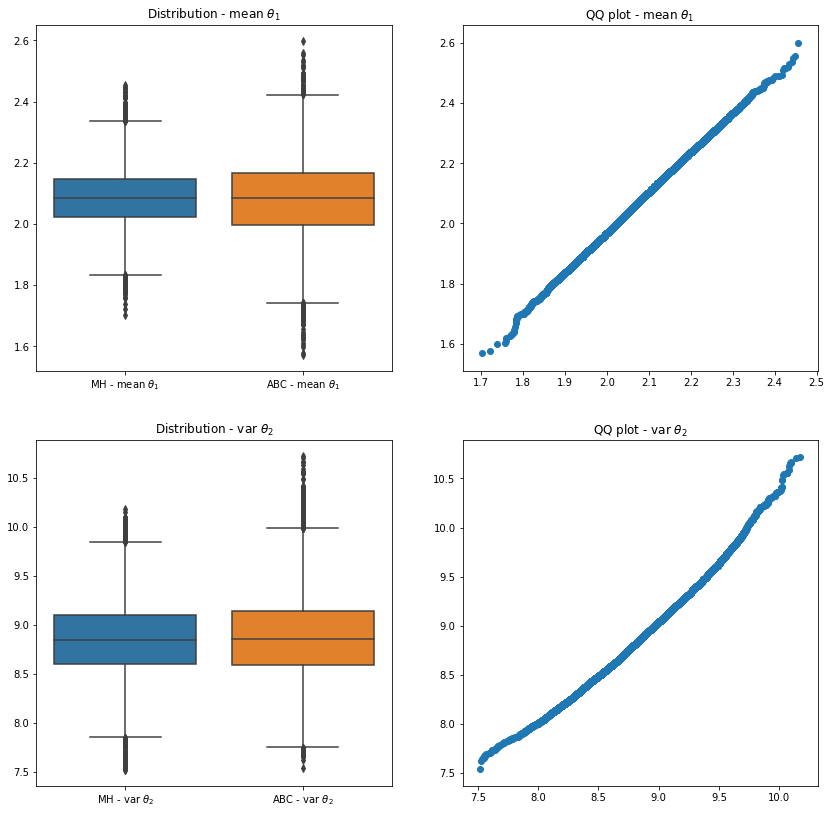

In [79]:
comparaison(data_mh_norm, data_abc_norm)

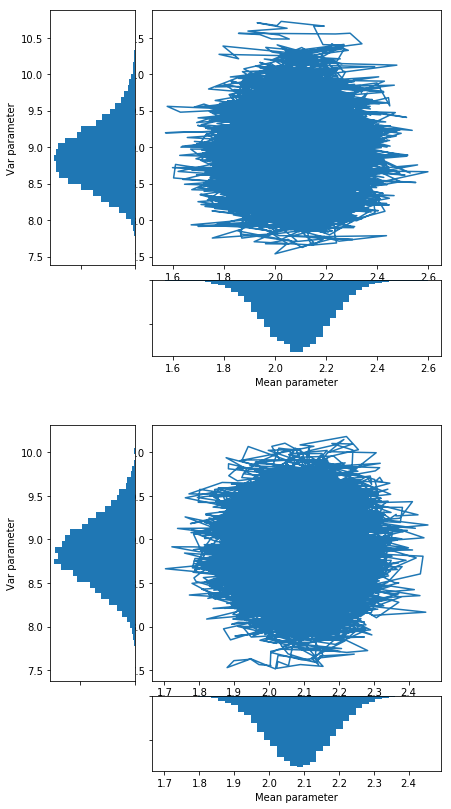

In [22]:
comparison_normal_2d_path(data_mh_norm, data_abc_norm)

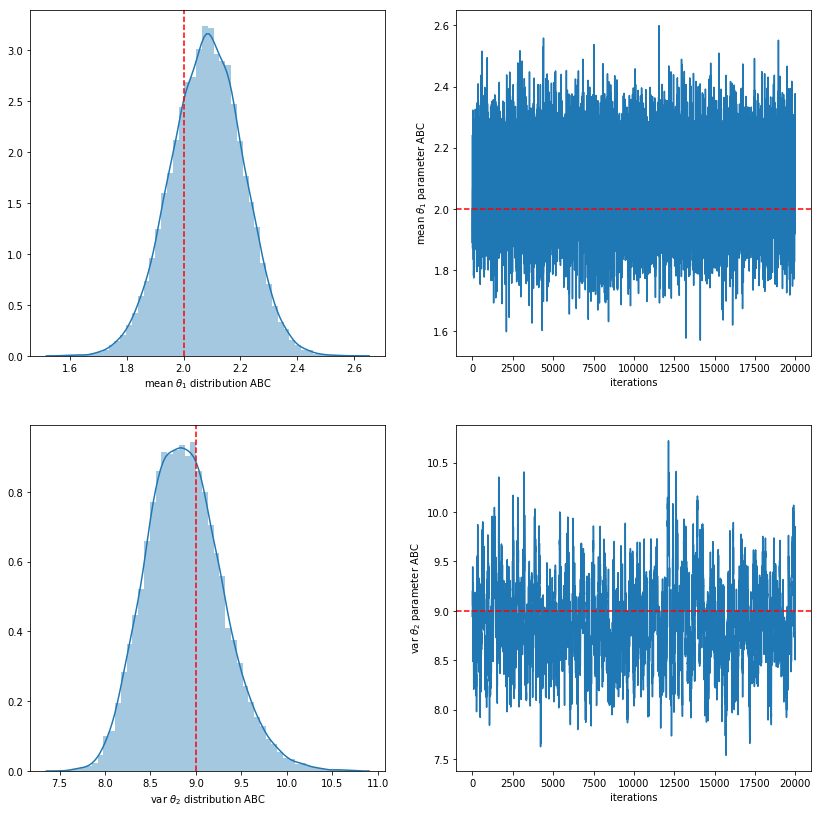

In [26]:
plot_marginals(data_abc_norm, [2,9])

## Posterior Approximation for a Binomial model

Let the probability density function for binomial distribution: $P(y | n, p) = {n \choose y} p^{y}(1-p)^{(n-y)} $

Where $n$ is the **number of trials**, p **probability of success** and $y$ the **number of successes in $n$ trials**.

We can express this probability density function as an exponential model :

$$P(y | n, \theta) = exp[y \theta - n log(1 + e^{\theta}) + log{n \choose y}] $$

And then express the posterior distribution of $\theta$ for a Binomial model:

$$P(\theta | y, n) \propto P(y | n, \theta) p(\theta) = exp[y \theta - n log(1 + e^{\theta}) + log{n \choose y}] P(\theta)$$


Where $\theta = log(\frac{p}{1 - p})$ and conversely $p = \frac{e^{\theta}}{1 + e^{\theta}}$ 


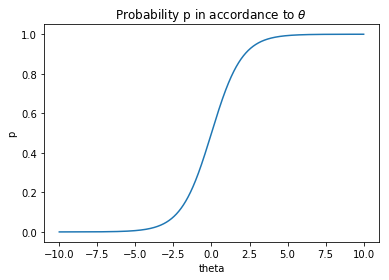

In [27]:
x = np.arange(-10,10, 0.001)
y = [exp(t)/(1 + exp(t)) for  t in x]
fig, ax = plt.subplots()
ax.set(xlabel='theta', ylabel='p',
       title=r'Probability p in accordance to $\theta$')
ax.plot(x,y)

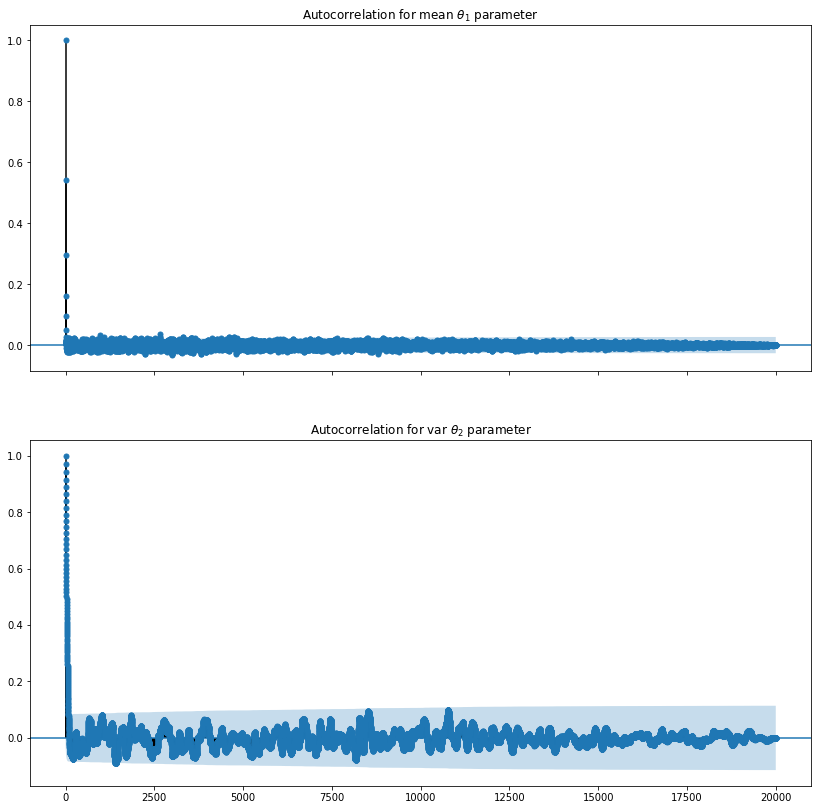

In [101]:
autocor(data_abc_norm)

In [73]:
FILE_NAME_ABC_BINOM = 'assets/binom/abc/binom_abc_100000.json'
data_abc_binom = extract_binom_from_file(FILE_NAME_ABC_BINOM, from_abc=True)

In [74]:
FILE_NAME_MH_BINOM = 'assets/binom/mh/binom_mh_100000.json'
data_mh_binom = extract_binom_from_file(FILE_NAME_MH_BINOM)

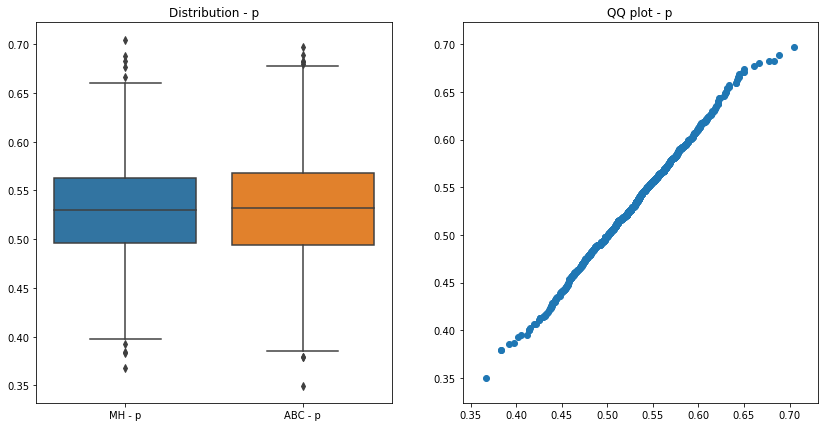

In [76]:
comparaison(data_mh_binom, data_abc_binom, burn_in=100, by= 100)

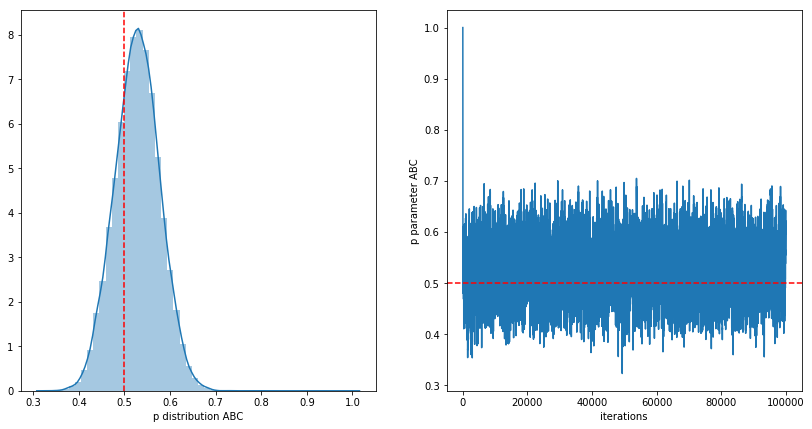

In [88]:
plot_marginals(data_mh_binom, [0.5])

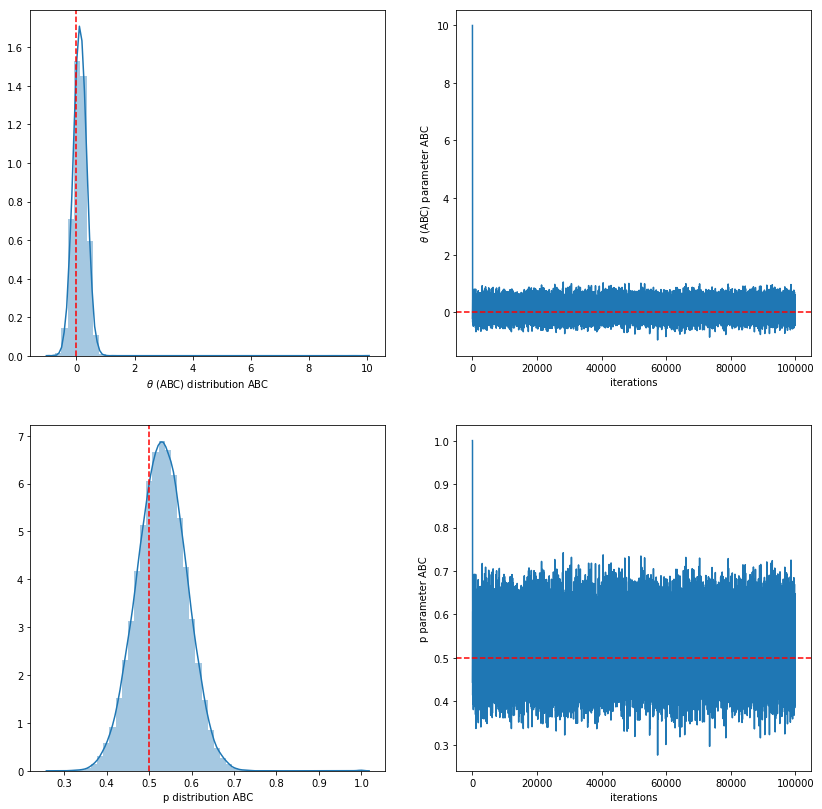

In [90]:
plot_marginals(data_abc_binom, [0, 0.5])

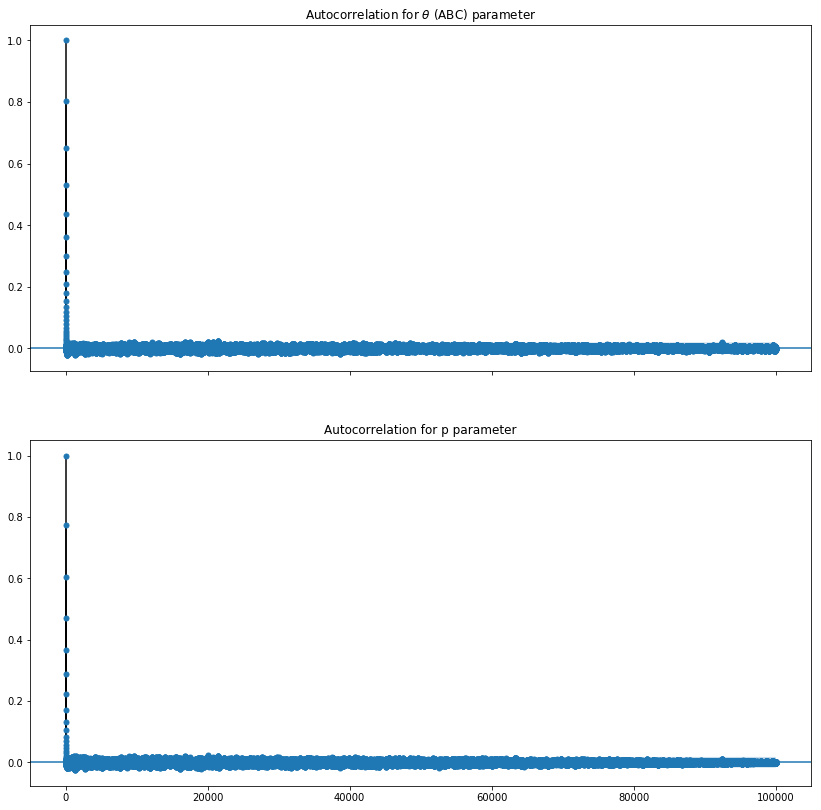

In [102]:
autocor(data_abc_binom)

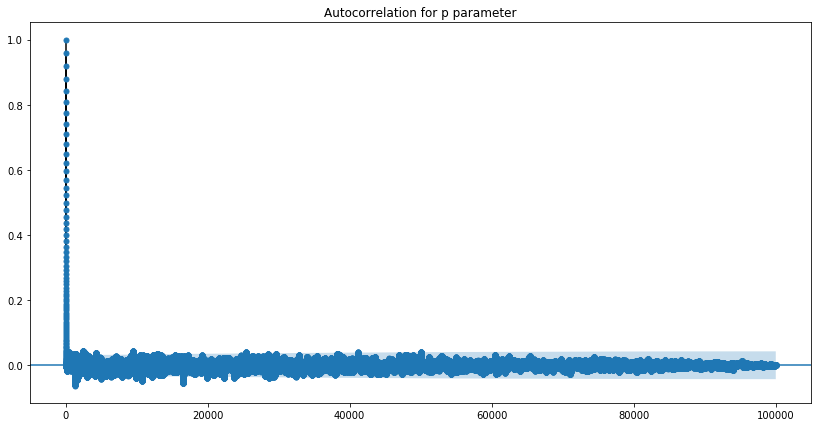

In [100]:
autocor(data_mh_binom)